In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy
from scipy.special import gamma
import matplotlib as mpl

STARTING_RANGE_PARAMETER = 0.1 # In [fm^-2]
ENDING_RANGE_PARAMETER = 25
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 40 # Determines the number of gaussians we expand our wave function to
CORE_MS_RADIUS = 2.30**2 # In fm^2, taken from p.232 of Tanihata et. al. (2013)

V_LS = 20.99 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [11.1111, 7.22509, 4.69817, 3.05502, 1.98655, 1.29177, 0.839985,
                                   0.546207, 0.355175, 0.230956, 0.150181, 0.0976562]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.0125374, -0.0512991, 0.148279, -0.274449, 0.257826, 0.258896,
                                  -1.36588, 1.22003, 2.19945, -3.41816, 0.115793, -0.0785824]


In [37]:
def gaussian_wavefunction(radius, range_parameter, theta, orb_ang_momentum):
    normalisation = (0.5 * (2 * range_parameter * np.exp(2j * theta))**(-1.5 - orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -12.41 * (-1)**orb_ang_momentum - 50.17 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
        

def complete_woods_saxon_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -12.41 * (-1)**orb_ang_momentum - 50.17 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

In [38]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * np.sqrt(range_param_i * range_param_j)) / (range_param_i + range_param_j))**(1.5 + orb_ang_momentum)

def potential_matrix_element(tot_ang_momentum, orb_ang_momentum, range_param_i, range_param_j, central_potential_mixing_coefficient,
                             central_potential_param, spin_orbit_potential_mixing_coefficient, spin_orbit_potential_param, theta, vls=V_LS):
    V_0 = -12.41 * (-1)**orb_ang_momentum - 50.17 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    
    central_potential_term = V_0 * central_potential_mixing_coefficient * ((2 * np.sqrt(range_param_i * range_param_j) * np.exp(-2j * theta)) / (
        (range_param_i + range_param_j) * np.exp(-2j * theta) + central_potential_param))**(1.5 + orb_ang_momentum)
    #central_potential_term = V_0 * central_potential_mixing_coefficient * ((2 * np.sqrt(range_param_i * range_param_j)) / (
    #    range_param_i + range_param_j + central_potential_param))**(1.5 + orb_ang_momentum)

    spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
        tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * ((
        2 * np.sqrt(range_param_i * range_param_j) * np.exp(-2j * theta)) / (
            np.exp(-2j * theta) * (range_param_i + range_param_j) + spin_orbit_potential_param))**(1.5 + orb_ang_momentum)
    #spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
    #    tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * ((
    #    2 * np.sqrt(range_param_i * range_param_j)) / (spin_orbit_potential_param + range_param_i + range_param_j))**(
    #    1.5 + orb_ang_momentum)

    return central_potential_term - spin_orbit_potential_term

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, theta, μ=REDUCED_MASS):
    term_1 = 2 * orb_ang_momentum + 3
    term_2 = (range_param_i * range_param_j)**(1.75 + (orb_ang_momentum / 2))
    term_3 = (2 / (range_param_i + range_param_j))**(2.5 + orb_ang_momentum)

    return (197**2 / (2 * μ)) * term_1 * term_2 * term_3 * np.exp(-2j * theta)

In [39]:
def matrix_generation(tot_ang_momentum, orb_ang_momentum, theta, central_mixing_coefficients=CENTRAL_MIXING_COEFFICIENTS,
                      central_potential_parameters=CENTRAL_POTENTIAL_PARAMETERS,
                      spin_orbit_potential_mixing_coefficients=SPIN_ORBIT_MIXING_COEFFICIENTS,
                      spin_orbit_potential_parameters=SPIN_ORBIT_POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size), dtype=np.complex_)
    n_matrix = np.zeros(shape=(size, size), dtype=np.complex_)
    #h_matrix = np.zeros(shape=(size, size))
    #n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter, theta)
            potential_energy_term = 0
            for k in range(len(central_mixing_coefficients)):
                potential_energy_term += potential_matrix_element(tot_ang_momentum, orb_ang_momentum, i_range_parameter,
                                                                  j_range_parameter, central_mixing_coefficients[k],
                                                                  central_potential_parameters[k], spin_orbit_potential_mixing_coefficients[k],
                                                                 spin_orbit_potential_parameters[k], theta)
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1

    return h_matrix, n_matrix


def next_range_parameter(i, starting_range_parameter=STARTING_RANGE_PARAMETER, ending_range_parameter=ENDING_RANGE_PARAMETER,
                         sum_limit=SUM_LIMIT):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    geometric_progression_number = (ending_range_parameter / starting_range_parameter)**(1 / (sum_limit - 1))
    new_range_parameter = starting_range_parameter * geometric_progression_number**(i)
    new_range_parameter = 1 / new_range_parameter**2

    return new_range_parameter

theta = 5 * np.pi / 36 
s_h_matrix, s_n_matrix = matrix_generation(0.5, 0, theta)
p_one_half_h_matrix, p_one_half_n_matrix = matrix_generation(0.5, 1, theta)
p_three_half_h_matrix, p_three_half_n_matrix = matrix_generation(1.5, 1, theta)
d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, theta)

In [40]:
s_eigenvalues, s_eigenvectors = scipy.linalg.eig(s_h_matrix, s_n_matrix)
s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
print(f"The s 1/2 overlap matrix condition number is", s_overlap_matrix_condition_number)

s0_eigenvector = np.asmatrix(s_eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(s_eigenvectors[:, 1])
print("The S state eigenvalues are", s_eigenvalues)
#print("The S1 eigenvector is", s1_eigenvector)
#print(s_eigenvalues[0])

The s 1/2 overlap matrix condition number is 23474779581343.137
The S state eigenvalues are [ 3.40041180e+04-4.05976006e+04j  2.31075672e+04-2.76112865e+04j
  1.64286510e+04-1.96513661e+04j  1.19211656e+04-1.42791974e+04j
  8.74905956e+03-1.04983525e+04j  6.46492712e+03-7.77561288e+03j
  4.79695050e+03-5.78704141e+03j  3.56773306e+03-4.32115257e+03j
  2.65632057e+03-3.23358360e+03j  1.97783755e+03-2.42294893e+03j
  1.47144448e+03-1.81662415e+03j  1.09294378e+03-1.36168852e+03j
  8.10232029e+02-1.01913819e+03j  6.00208270e+02-7.60492353e+02j
  4.45728816e+02-5.65775020e+02j  3.32654501e+02-4.20889562e+02j
  2.48782470e+02-3.14436325e+02j  1.85019717e+02-2.35835737e+02j
  1.36443926e+02-1.76491897e+02j  1.00376136e+02-1.31376206e+02j
  7.38650067e+01-9.76074416e+01j  5.41372191e+01-7.24016543e+01j
  3.95891440e+01-5.34195884e+01j  2.90224004e+01-3.93241848e+01j
 -3.27751113e+01-3.24984516e-06j  2.11906220e+01-2.89580763e+01j
  1.53491137e+01-2.12201745e+01j  1.10873826e+01-1.54165513e+01

In [41]:
p_one_half_eigenvalues, p_one_half_eigenvectors = scipy.linalg.eig(p_one_half_h_matrix, p_one_half_n_matrix)
p_one_half_overlap_eigenvalues, p_one_half_overlap_eigenvectors = scipy.linalg.eigh(p_one_half_n_matrix)
p_one_half_overlap_matrix_condition_number = np.max(p_one_half_overlap_eigenvalues) / np.min(p_one_half_overlap_eigenvalues)
print(f"The P 1/2 overlap matrix condition number is", p_one_half_overlap_matrix_condition_number)

zero_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 0])
one_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 1])
print("The P 1/2 state eigenvalues are", p_one_half_eigenvalues)
#print("The 0P1/2 eigenvector is", zero_p_one_half_eigenvector)

The P 1/2 overlap matrix condition number is 1294990422764.1138
The P 1/2 state eigenvalues are [3.59799569e+04-4.29223270e+04j 2.45265096e+04-2.92719881e+04j
 1.74802004e+04-2.08740681e+04j 1.27114962e+04-1.51905824e+04j
 9.34811386e+03-1.11818815e+04j 6.92189055e+03-8.28996841e+03j
 5.14754695e+03-6.17484922e+03j 3.83835758e+03-4.61394251e+03j
 2.86665242e+03-3.45493305e+03j 2.14260860e+03-2.59061629e+03j
 1.60169091e+03-1.94406604e+03j 1.19690697e+03-1.45917155e+03j
 8.94009937e+02-1.09464076e+03j 6.67844416e+02-8.20347483e+02j
 4.99353931e+02-6.14213784e+02j 3.74000103e+02-4.59798549e+02j
 2.80403347e+02-3.44686716e+02j 2.09871547e+02-2.58846725e+02j
 1.56508596e+02-1.94349728e+02j 1.16403356e+02-1.45566408e+02j
 8.65829436e+01-1.08762788e+02j 6.44016208e+01-8.12151788e+01j
 4.78053098e+01-6.05834713e+01j 3.54319668e+01-4.50678793e+01j
 2.62889116e+01-3.34654774e+01j 1.94628319e+01-2.48663110e+01j
 1.43133812e+01-1.84305926e+01j 1.04731047e+01-1.35753200e+01j
 7.63942572e+00-9.9303

In [42]:
p_three_half_eigenvalues, p_three_half_eigenvectors = scipy.linalg.eig(p_three_half_h_matrix, p_three_half_n_matrix)
p_three_half_overlap_eigenvalues, p_three_half_overlap_eigenvectors = scipy.linalg.eigh(p_three_half_n_matrix)
p_three_half_overlap_matrix_condition_number = np.max(p_three_half_overlap_eigenvalues) / np.min(p_three_half_overlap_eigenvalues)
print(f"The P 3/2 overlap matrix condition number is", p_three_half_overlap_matrix_condition_number)

zero_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 0])
one_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 1])
print("The P 3/2 state eigenvalues are", p_three_half_eigenvalues)
#print("The 0P3/2 eigenvector is", zero_p_three_half_eigenvector)

The P 3/2 overlap matrix condition number is 1294990422764.1138
The P 3/2 state eigenvalues are [ 3.59789685e+04-4.29226737e+04j  2.45250597e+04-2.92724932e+04j
  1.74783965e+04-2.08745782e+04j  1.27094457e+04-1.51910419e+04j
  9.34589384e+03-1.11822987e+04j  6.91953600e+03-8.29037237e+03j
  5.14507334e+03-6.17526720e+03j  3.83577065e+03-4.61441808e+03j
  2.86391224e+03-3.45552546e+03j  2.13962388e+03-2.59133914e+03j
  1.59839328e+03-1.94486726e+03j  1.19325163e+03-1.46002015e+03j
  8.89821147e+02-1.09543077e+03j  6.63072002e+02-8.20593712e+02j
  4.94557176e+02-6.13461064e+02j  3.69912734e+02-4.58220511e+02j
  2.77375781e+02-3.42853675e+02j  2.07742844e+02-2.57356756e+02j
  1.54751097e+02-1.93378507e+02j  1.14719694e+02-1.44818815e+02j
  8.50606965e+01-1.08019068e+02j  6.31574410e+01-8.05056764e+01j
  4.67679711e+01-6.00068028e+01j  3.44959111e+01-4.45276636e+01j
  2.55555810e+01-3.28844241e+01j  1.89855538e+01-2.43632889e+01j
  1.39803284e+01-1.80753791e+01j  1.02036687e+01-1.33241796

In [43]:
d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
d_five_half_overlap_eigenvalues, d_five_half_overlap_eigenvectors = scipy.linalg.eigh(d_five_half_n_matrix)
d_five_half_overlap_matrix_condition_number = np.max(d_five_half_overlap_eigenvalues) / np.min(d_five_half_overlap_eigenvalues)
print(f"The D 5/2 overlap matrix condition number is", d_five_half_overlap_matrix_condition_number)

zero_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 0])
one_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 1])
print("The D 5/2 state eigenvalues are", d_five_half_eigenvalues)
#print("The 0D5/2 eigenvector is", zero_d_five_half_eigenvector)
#print(d_five_half_eigenvalues[33])
#print(d_five_half_eigenvalues[34])
#print(d_five_half_eigenvalues[35])
#print(d_five_half_eigenvalues[33:36])

The D 5/2 overlap matrix condition number is 128692128724.63907
The D 5/2 state eigenvalues are [3.79540955e+04-4.53060652e+04j 2.59337806e+04-3.09809937e+04j
 1.85114020e+04-2.21353640e+04j 1.34743286e+04-1.61322624e+04j
 9.91396181e+03-1.18888665e+04j 7.34116842e+03-8.82226919e+03j
 5.45698375e+03-6.57619876e+03j 4.06515576e+03-4.91674783e+03j
 3.03111082e+03-3.68340767e+03j 2.25995724e+03-2.76286045e+03j
 1.68347273e+03-2.07360295e+03j 1.25188258e+03-1.55614481e+03j
 9.28730123e+02-1.16645834e+03j 6.87586573e+02-8.71939575e+02j
 5.09361026e+02-6.49085983e+02j 3.79360085e+02-4.81831271e+02j
 2.84396230e+02-3.58737054e+02j 2.12790940e+02-2.68964738e+02j
 1.57515303e+02-2.01855816e+02j 1.15981224e+02-1.50353498e+02j
 8.58297615e+01-1.11496171e+02j 6.36161166e+01-8.28532435e+01j
 4.68724307e+01-6.14384435e+01j 3.46399615e+01-4.51745307e+01j
 2.59445083e+01-3.32442406e+01j 1.94049122e+01-2.47254608e+01j
 1.43045001e+01-1.83720280e+01j 1.04994775e+01-1.35319589e+01j
 7.70148078e+00-9.9049

In [44]:
theta_values = np.linspace(0, 0.2, 100)
d_five_halfs_eigenvalue_theta_matrix = np.zeros(shape=(len(theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(theta_values):
    d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, i[1])
    d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
    d_five_halfs_eigenvalue_theta_matrix[i[0], :] = d_five_half_eigenvalues

s_half_eigenvalue_theta_matrix = np.zeros(shape=(len(theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(theta_values):
    s_h_matrix, s_n_matrix = matrix_generation(0.5, 0, i[1])
    s_eigenvalues, s_eigenvectors = scipy.linalg.eig(s_h_matrix, s_n_matrix)
    s_half_eigenvalue_theta_matrix[i[0], :] = s_eigenvalues

d_three_halfs_eigenvalue_theta_matrix = np.zeros(shape=(len(theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(theta_values):
    d_three_half_h_matrix, d_three_half_n_matrix = matrix_generation(1.5, 2, i[1])
    d_three_half_eigenvalues, d_three_half_eigenvectors = scipy.linalg.eig(d_three_half_h_matrix, d_three_half_n_matrix)
    d_three_halfs_eigenvalue_theta_matrix[i[0], :] = d_three_half_eigenvalues

#print(d_five_halfs_eigenvalue_theta_matrix)
#print(s_half_eigenvalue_theta_matrix)

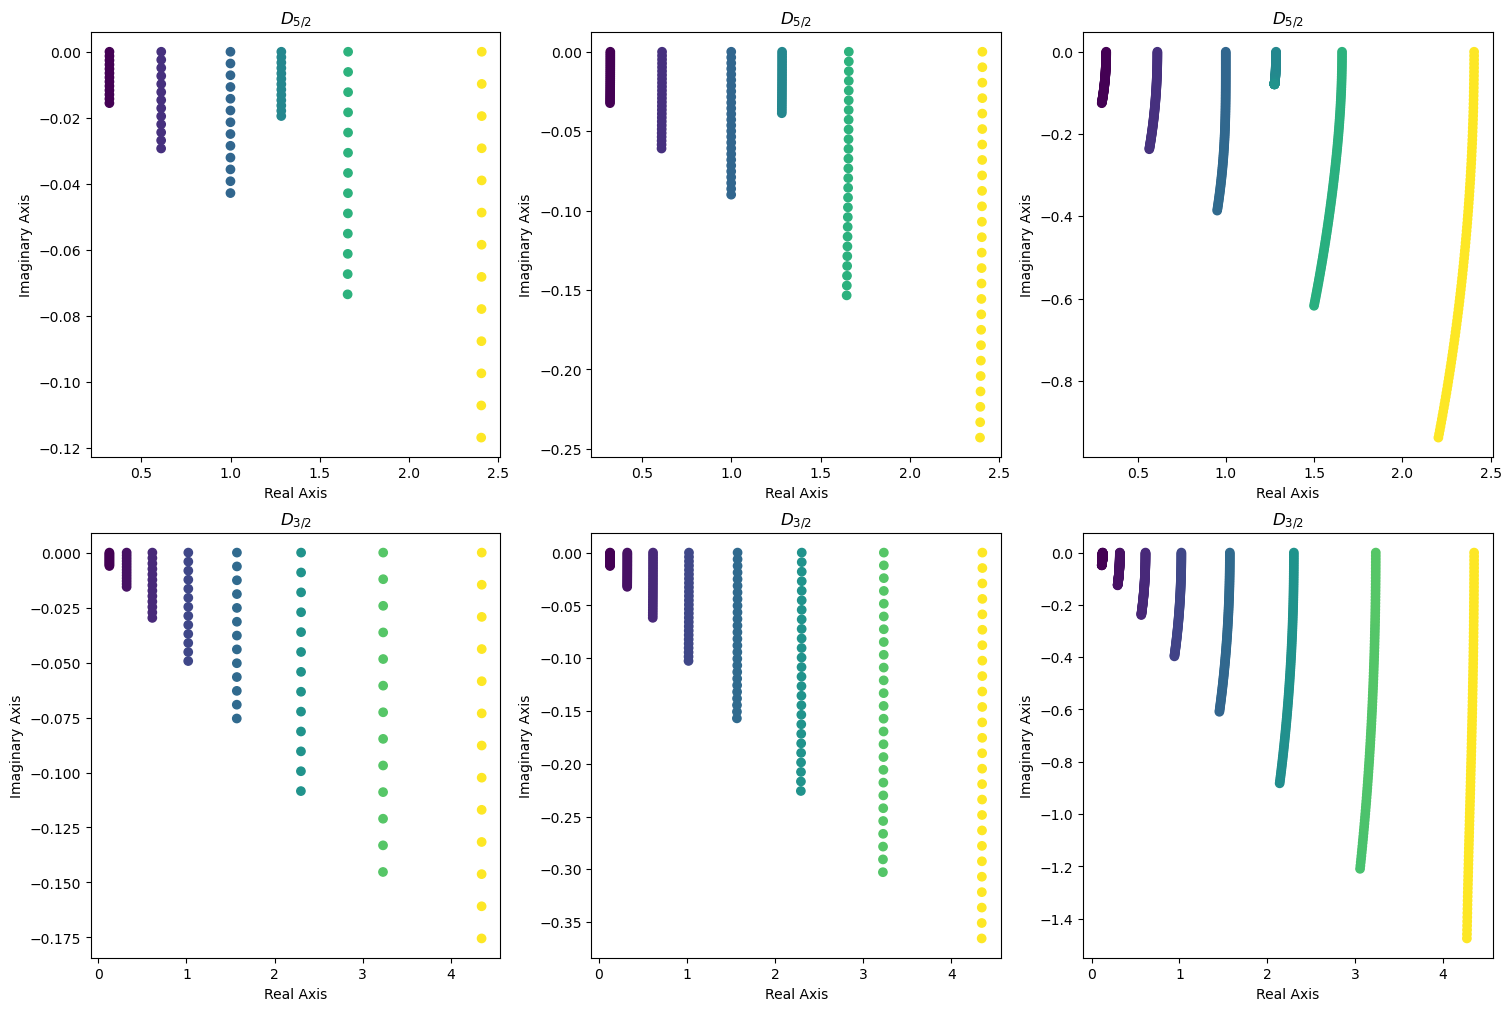

In [45]:
fig = plt.figure(figsize=(15, 10), layout='constrained')
spec = fig.add_gridspec(ncols=3, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[0, 2])
ax_4 = fig.add_subplot(spec[1, 0])
ax_5 = fig.add_subplot(spec[1, 1])
ax_6 = fig.add_subplot(spec[1, 2])

theta_values_parital_1 = np.linspace(0, 0.2 * 0.33333, 13)
theta_values_parital_2 = np.linspace(0, 0.2 * 0.66666, 26)


for i in enumerate(theta_values_parital_1):
    ax_1.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
ax_1.set_xlabel('Real Axis')
ax_1.set_ylabel('Imaginary Axis')
ax_1.set_title(r'$D_{5/2}$')

for i in enumerate(theta_values_parital_2):
    ax_2.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
ax_2.set_xlabel('Real Axis')
ax_2.set_ylabel('Imaginary Axis')
ax_2.set_title(r'$D_{5/2}$')

for i in enumerate(theta_values):
    ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
# ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[39, 35]), np.imag(d_five_halfs_eigenvalue_theta_matrix[39, 35]), c='r')
ax_3.set_xlabel('Real Axis')
ax_3.set_ylabel('Imaginary Axis')
ax_3.set_title(r'$D_{5/2}$')

"""
ax_1.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[13, 33:39]),
             np.imag(d_five_halfs_eigenvalue_theta_matrix[13, 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[13, 33:39]), cmap='viridis')
ax_2.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[26, 33:39]),
             np.imag(d_five_halfs_eigenvalue_theta_matrix[26, 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[26, 33:39]), cmap='viridis')
ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[40, 33:39]),
             np.imag(d_five_halfs_eigenvalue_theta_matrix[40, 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[40, 33:39]), cmap='viridis')
ax_1.set_xlabel('Real Axis')
ax_1.set_ylabel('Imaginary Axis')
ax_1.set_title(r'$D_{5/2}$')
ax_2.set_xlabel('Real Axis')
ax_2.set_ylabel('Imaginary Axis')
ax_2.set_title(r'$D_{5/2}$')
ax_3.set_xlabel('Real Axis')
ax_3.set_ylabel('Imaginary Axis')
ax_3.set_title(r'$D_{5/2}$')
"""

a = 32

b = 40

for i in enumerate(theta_values_parital_1):
    ax_4.scatter(np.real(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]),
               np.imag(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), c=(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), cmap='viridis')
ax_4.set_xlabel('Real Axis')
ax_4.set_ylabel('Imaginary Axis')
ax_4.set_title(r'$D_{3/2}$')

for i in enumerate(theta_values_parital_2):
    ax_5.scatter(np.real(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]),
               np.imag(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), c=(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), cmap='viridis')
ax_5.set_xlabel('Real Axis')
ax_5.set_ylabel('Imaginary Axis')
ax_5.set_title(r'$D_{3/2}$')

for i in enumerate(theta_values):
    #print(d_three_halfs_eigenvalue_theta_matrix[i[0], 33:39])
    ax_6.scatter(np.real(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]),
               np.imag(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), c=(d_three_halfs_eigenvalue_theta_matrix[i[0], a:b]), cmap='viridis')
# ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[39, 35]), np.imag(d_five_halfs_eigenvalue_theta_matrix[39, 35]), c='r')
ax_6.set_xlabel('Real Axis')
ax_6.set_ylabel('Imaginary Axis')
ax_6.set_title(r'$D_{3/2}$')

plt.savefig('D_five_half_resonace.png')
plt.show()
plt.close()

In [46]:
print(d_five_halfs_eigenvalue_theta_matrix[39, 35])
print(d_five_halfs_eigenvalue_theta_matrix[0, 35])

print(d_five_halfs_eigenvalue_theta_matrix[0, 33])

(1.2804952962427727-0.05544132656250063j)
(1.2840521030103067+1.5799225121494409e-09j)
(2.4064854951568915+3.8936548661632705e-09j)


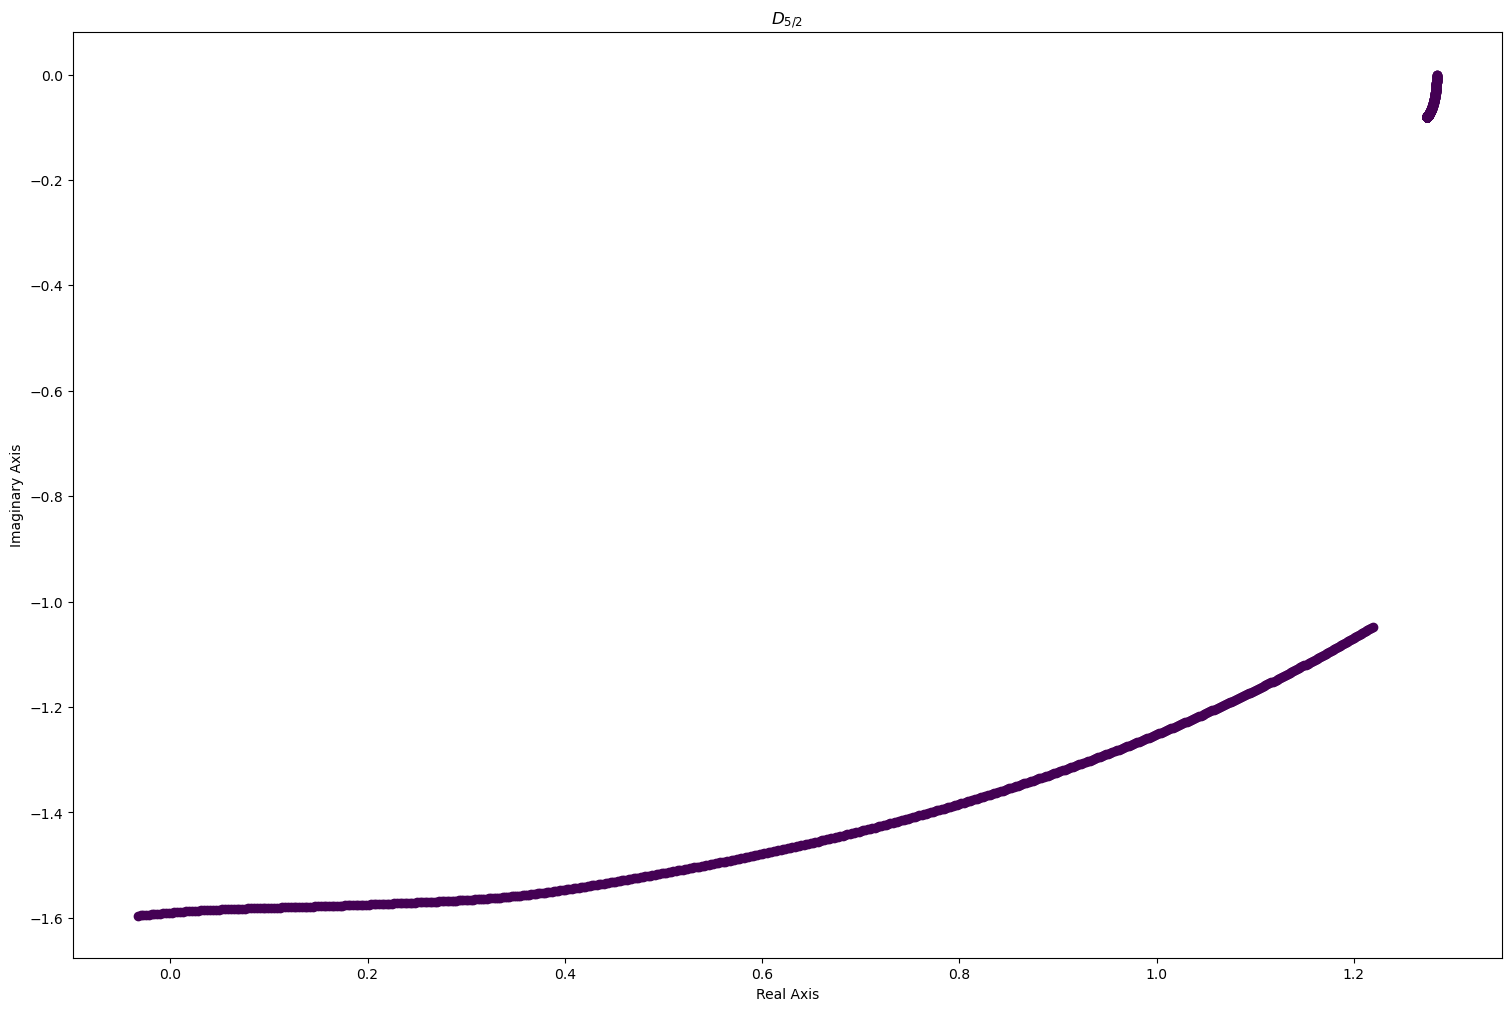

In [47]:
constrained_theta_values = np.linspace(0, np.pi / 4, 1000)
d_five_half_eigen_matrix = np.zeros(shape=(len(constrained_theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(constrained_theta_values):
    d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, i[1])
    d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
    d_five_half_eigen_matrix[i[0], :] = d_five_half_eigenvalues

fig = plt.figure(figsize=(15, 10), layout='constrained')
ax = fig.add_subplot()

for i in enumerate(constrained_theta_values):
    ax.scatter(np.real(d_five_half_eigen_matrix[i[0], 35]),
                np.imag(d_five_half_eigen_matrix[i[0], 35]), c=(d_five_half_eigen_matrix[i[0], 35]), cmap='viridis')
ax.set_xlabel('Real Axis')
ax.set_ylabel('Imaginary Axis')
ax.set_title(r'$D_{5/2}$')
plt.show()
plt.close()


Minimum energy value of the resonace is at (1.2739482020346875-0.08028319481413869j)
Value where minimum change of energy occurs is at [1.2739482-0.08028312j]


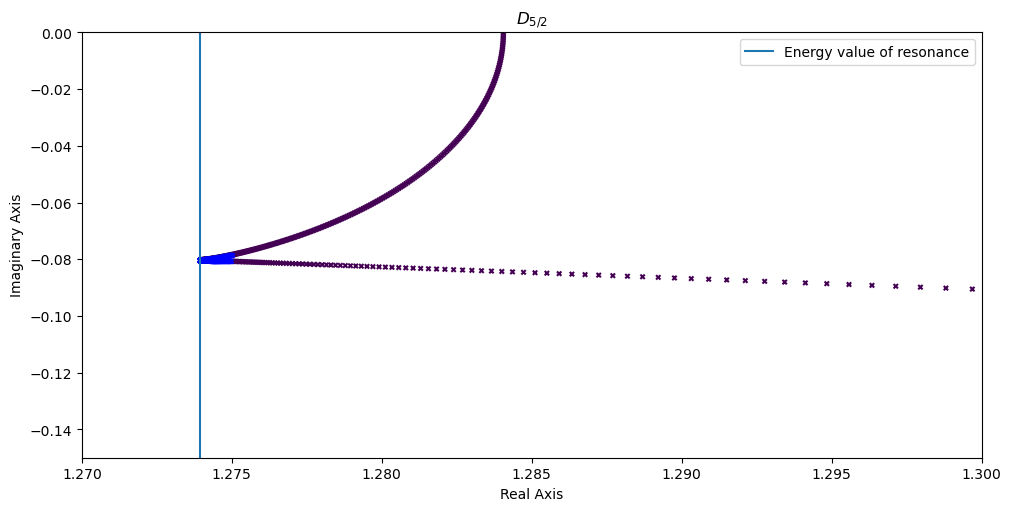

In [78]:
fig = plt.figure(figsize=(10, 5), layout='constrained')
ax = fig.add_subplot()

constrained_region_matrix = np.zeros(shape=(0, 2))


for i in enumerate(constrained_theta_values):
    for j in range(SUM_LIMIT):
        if 1.22 < np.real(d_five_half_eigen_matrix[i[0], j]) < 1.275 and -0.1 < np.imag(d_five_half_eigen_matrix[i[0], j]) < -0.029:
            constrained_region_matrix = np.append(constrained_region_matrix, d_five_half_eigen_matrix[i[0], j])
print(f'Minimum energy value of the resonace is at {np.min(constrained_region_matrix)}')

change_in_energy = np.zeros(shape=(1, len(constrained_region_matrix)-1))
for i in enumerate(change_in_energy[0, :]):
    change_in_energy[0, i[0]] = np.abs(constrained_region_matrix[i[0] + 1] - constrained_region_matrix[i[0]])
change_in_energy = change_in_energy[0, :]
print(f'Value where minimum change of energy occurs is at {constrained_region_matrix[np.where(change_in_energy == change_in_energy.min())]}')


for i in enumerate(constrained_theta_values):
    ax.scatter(np.real(d_five_half_eigen_matrix[i[0], :]),
               np.imag(d_five_half_eigen_matrix[i[0], :]), marker='x', s=10, c=(d_five_half_eigen_matrix[i[0], :]), cmap='viridis')
ax.scatter(np.real(constrained_region_matrix),
            np.imag(constrained_region_matrix), marker='x', s=10, c='b')
#ax.scatter(1.274, -0.05, s = 100, c='r')
ax.plot(np.linspace(1.2739482020346875, 1.2739482020346875, 100), np.linspace(-0.15, 0.03, 100), label='Energy value of resonance')
ax.set_xlabel('Real Axis')
ax.set_ylabel('Imaginary Axis')
ax.set_title(r'$D_{5/2}$')
ax.set_xlim(left=1.27, right=1.30)
ax.set_ylim(bottom=-0.15, top=-0.0)
ax.legend()
#ax.set_xlim(left=1, right=2)
#ax.set_ylim(bottom=-2, top=0)
plt.savefig('Resonance_location.png')
plt.show()
plt.close()

In [49]:
new_constrained_theta_values = np.linspace(0, 21 * np.pi / 180, 21)
new_constrained_d_five_half_eigen_matrix = np.zeros(shape=(len(new_constrained_theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(new_constrained_theta_values):
    d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, i[1])
    d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
    new_constrained_d_five_half_eigen_matrix[i[0], :] = d_five_half_eigenvalues

[5.90806514e+04-1.34695417e-09j 4.03804997e+04-9.56615324e-10j
 2.88334705e+04-5.66708510e-10j 2.09972809e+04-3.64432650e-10j
 1.54583837e+04-1.75740647e-10j 1.14558359e+04-1.12946547e-10j
 8.52458388e+03-1.77691119e-10j 6.35938795e+03-2.32942507e-10j
 4.75091968e+03-2.75110732e-10j 3.55148734e+03-1.40219010e-10j
 2.65488639e+03+1.58334155e-12j 1.98374893e+03+8.79024901e-13j
 1.48119992e+03+4.64537690e-12j 1.10512237e+03+8.10188188e-12j
 8.24076957e+02-4.89712003e-11j 6.14364125e+02-1.16090372e-10j
 4.57981836e+02-9.18740011e-12j 3.41294443e+02+1.57173191e-10j
 2.54130745e+02+7.39871839e-11j 1.89011644e+02-1.08392712e-10j
 1.40419043e+02-2.71793532e-10j 1.04218442e+02-6.68151855e-10j
 7.72918183e+01-1.59260905e-09j 5.72942826e+01-3.86089308e-09j
 4.24567965e+01-9.48441936e-09j 3.14403472e+01-2.21927734e-08j
 2.32457602e+01-1.35356270e-08j 1.71426266e+01+1.75490885e-09j
 1.25977025e+01+4.30750018e-09j 9.21572925e+00+9.06009913e-09j
 6.70041675e+00+1.49541933e-08j 4.82969973e+00+1.711358

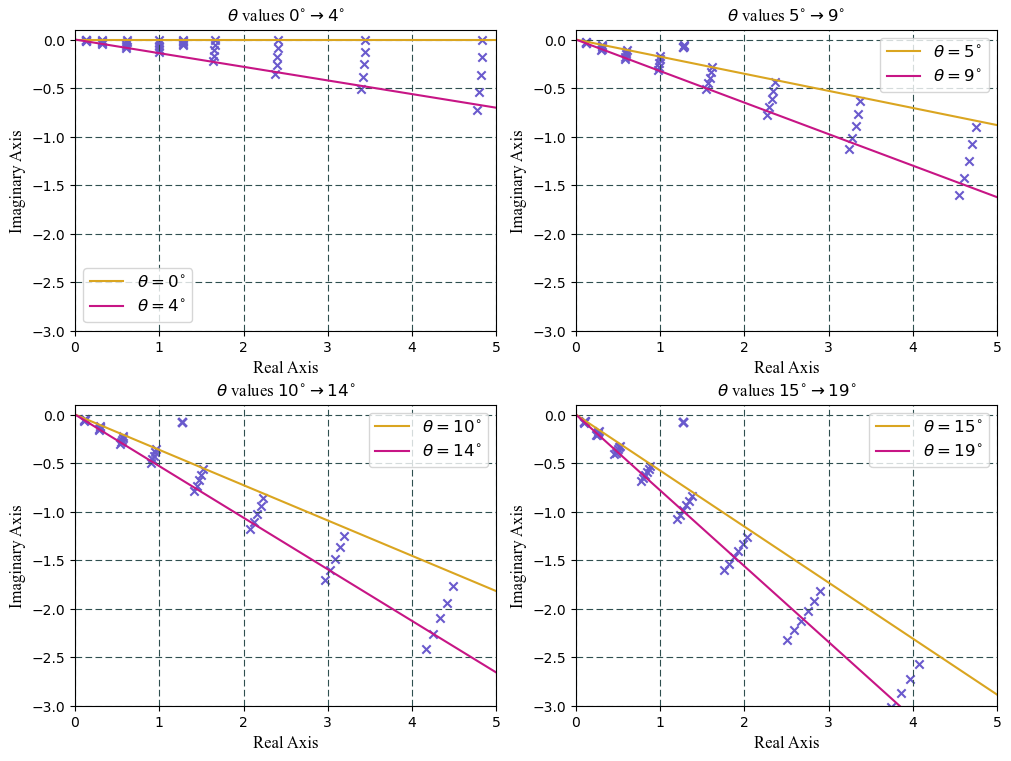

In [50]:
def straight_line_angle(x_vals, theta):
    theta = 2 * theta * np.pi / 180
    return x_vals * np.tan(-theta)

x_vals = np.linspace(0, 5, 100)

font_size_variable = 12
legend_font = font_manager.FontProperties(family='Times New Roman',
                                          style='normal', size=12)

fig = plt.figure(figsize=(10, 7.5), layout='constrained')
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

ax_1_annotate = (r'$\theta$ values $0^{\circ} \rightarrow 4^{\circ}$')
ax_2_annotate = (r'$\theta$ values $5^{\circ} \rightarrow 9^{\circ}$')
ax_3_annotate = (r'$\theta$ values $10^{\circ} \rightarrow 14^{\circ}$')
ax_4_annotate = (r'$\theta$ values $15^{\circ} \rightarrow 19^{\circ}$')

print(new_constrained_d_five_half_eigen_matrix[0, :])

for i in enumerate(new_constrained_theta_values):
    if i[0] < 5:
        ax_1.scatter(np.real(new_constrained_d_five_half_eigen_matrix[i[0], :]),
                     np.imag(new_constrained_d_five_half_eigen_matrix[i[0], :]), c='slateblue', marker='x')
ax_1.set_xlim(left=0, right=5)
ax_1.set_ylim(bottom=-3, top=0.1)
ax_1.set_xlabel('Real Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_1.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_1.plot(x_vals, straight_line_angle(x_vals, 0), label=r'$\theta = 0^{\circ}$', c='goldenrod')
ax_1.plot(x_vals, straight_line_angle(x_vals, 4), label=r'$\theta = 4^{\circ}$', c='mediumvioletred')
ax_1.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_1.set_title(ax_1_annotate, fontsize=font_size_variable, fontname='Times New Roman')
ax_1.legend(prop=legend_font)
#ax_1.annotate(ax_1_annotate, xy=(0.16, 0.14), xycoords='figure fraction',
#              fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))

for i in enumerate(new_constrained_theta_values):
    if 4 < i[0] < 10:
        ax_2.scatter(np.real(new_constrained_d_five_half_eigen_matrix[i[0], :]),
                     np.imag(new_constrained_d_five_half_eigen_matrix[i[0], :]), c='slateblue', marker='x')
ax_2.set_xlim(left=0, right=5)
ax_2.set_ylim(bottom=-3, top=0.1)
ax_2.set_xlabel('Real Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_2.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_2.plot(x_vals, straight_line_angle(x_vals, 5), label=r'$\theta = 5^{\circ}$', c='goldenrod')
ax_2.plot(x_vals, straight_line_angle(x_vals, 9), label=r'$\theta = 9^{\circ}$', c='mediumvioletred')
ax_2.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_2.legend(prop=legend_font)
ax_2.set_title(ax_2_annotate, fontsize=font_size_variable, fontname='Times New Roman')

for i in enumerate(new_constrained_theta_values):
    if 9 < i[0] < 15:
        ax_3.scatter(np.real(new_constrained_d_five_half_eigen_matrix[i[0], :]),
                     np.imag(new_constrained_d_five_half_eigen_matrix[i[0], :]), c='slateblue', marker='x')
ax_3.set_xlim(left=0, right=5)
ax_3.set_ylim(bottom=-3, top=0.1)
ax_3.set_xlabel('Real Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_3.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_3.plot(x_vals, straight_line_angle(x_vals, 10), label=r'$\theta = 10^{\circ}$', c='goldenrod')
ax_3.plot(x_vals, straight_line_angle(x_vals, 14), label=r'$\theta = 14^{\circ}$', c='mediumvioletred')
ax_3.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_3.legend(prop=legend_font)
ax_3.set_title(ax_3_annotate, fontsize=font_size_variable, fontname='Times New Roman')

for i in enumerate(new_constrained_theta_values):
    if 14 < i[0]:
        ax_4.scatter(np.real(new_constrained_d_five_half_eigen_matrix[i[0], 30:]),
                     np.imag(new_constrained_d_five_half_eigen_matrix[i[0], 30:]), c='slateblue', marker='x')
ax_4.set_xlim(left=0, right=5)
ax_4.set_ylim(bottom=-3, top=0.1)
ax_4.set_xlabel('Real Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_4.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_4.plot(x_vals, straight_line_angle(x_vals, 15), label=r'$\theta = 15^{\circ}$', c='goldenrod')
ax_4.plot(x_vals, straight_line_angle(x_vals, 19), label=r'$\theta = 19^{\circ}$', c='mediumvioletred')
ax_4.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_4.legend(prop=legend_font)
ax_4.set_title(ax_4_annotate, fontsize=font_size_variable, fontname='Times New Roman')
plt.savefig('Complex_shifting.png')

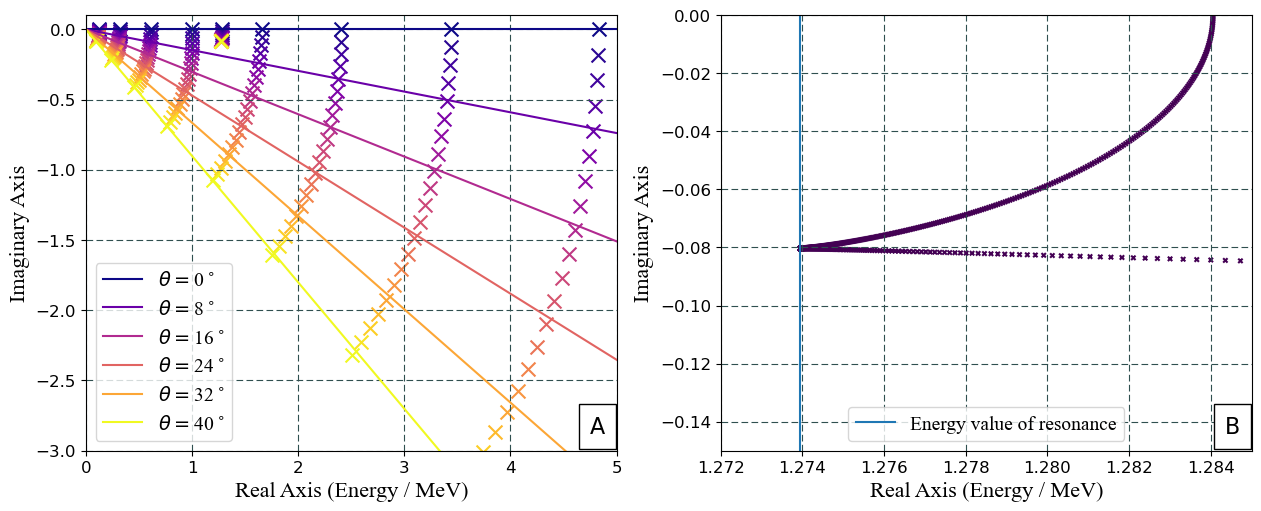

In [94]:
def straight_line_angle(x_vals, theta):
    # theta = 2 * theta * np.pi / 180
    return x_vals * np.tan(- 2 * theta)


x_vals = np.linspace(0, 5, 1000)

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 21))
font_size_variable = 16
tick_size_variable = 12
legend_font = font_manager.FontProperties(family='Times New Roman',
                                          style='normal', size=14)

fig = plt.figure(figsize=(12.5, 5), layout='constrained')
spec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])

ax_1_title = (r'$\theta$ values $0^{\circ} \rightarrow 4^{\circ}$')

#print(new_constrained_d_five_half_eigen_matrix)

for i in enumerate(new_constrained_theta_values):
    ax_1.scatter(np.real(new_constrained_d_five_half_eigen_matrix[i[0], :]),
                 np.imag(new_constrained_d_five_half_eigen_matrix[i[0], :]), color=colors[i[0]], marker='x', s=100)
    if i[0] % 4 == 0:
        line_label_1 = fr'$\theta =${i[0] * 2}'
        line_label_2 = r'$^\circ$'
        line_label = line_label_1 + line_label_2
        ax_1.plot(x_vals, straight_line_angle(x_vals, i[1]), label=line_label, color=colors[i[0]])
# label=(r'$\theta', f'= {i[1] * 180 / np.pi:.1f}', r'^{\circ}$'),
        
    
ax_1.set_xlim(left=0, right=5)
ax_1.set_ylim(bottom=-3, top=0.1)
ax_1.set_xlabel('Real Axis (Energy / MeV)', fontsize=font_size_variable, fontname='Times New Roman')
ax_1.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_1.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_1.annotate('A', xy=(0.95, 0.04), xycoords='axes fraction',
            fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
ax_1.tick_params(axis='both', labelsize=tick_size_variable)
ax_1.legend(prop=legend_font)


for i in enumerate(constrained_theta_values):
    ax_2.scatter(np.real(d_five_half_eigen_matrix[i[0], :]),
                 np.imag(d_five_half_eigen_matrix[i[0], :]), marker='x', s=10, c=(d_five_half_eigen_matrix[i[0], :]), cmap='viridis')
#ax.scatter(1.274, -0.05, s = 100, c='r')
ax_2.plot(np.linspace(1.2739482020346875, 1.2739482020346875, 100), np.linspace(-0.15, 0.03, 100), label='Energy value of resonance')
ax_2.set_xlabel('Real Axis (Energy / MeV)', fontsize=font_size_variable, fontname='Times New Roman')
ax_2.set_ylabel('Imaginary Axis', fontsize=font_size_variable, fontname='Times New Roman')
ax_2.set_xlim(left=1.272, right=1.285)
ax_2.set_ylim(bottom=-0.15, top=-0.0)
ax_2.grid(color='darkslategrey', dashes=[6, 3, 6, 3])
ax_2.annotate('B', xy=(0.95, 0.04), xycoords='axes fraction',
            fontsize='16', bbox=dict(boxstyle="square,pad=.5", fc="white"))
ax_2.tick_params(axis='both', labelsize=tick_size_variable)
ax_2.legend(loc='lower center', prop=legend_font)


plt.savefig('Complex_resonance_plot.png')